In [3]:
from plotting import imshow
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# RGB training data load
yuv_train_set = unpickle('yuv_train')

# Image names 
filenames = [f.decode('utf-8') for f in yuv_train_set[b'filenames']]

# Getting the images
yuv_images_data = yuv_train_set[b'data'].copy() 

In [4]:
def yuv_rgb(array):
    new_array = array.numpy().copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    
    return torch.tensor((new_array*255).astype(np.uint32)).permute(2, 0, 1)

In [5]:
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50):
        self.filenames = filenames # image name
        self.images_data = images_data # images data: data used to construct the images 
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v

    def __len__(self):
        return len(self.filenames)
    
    def bin_labels(self, values):
        return np.digitize(values, self.bins) -1 # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint32)

        Y_channel = (img[0:1024].reshape(32, 32, 1) / 255).astype(np.float32)
        U_channel = (img[1024:2048].reshape(32, 32, 1) / 255).astype(np.float32)
        V_channel = (img[2048:].reshape(32, 32, 1) / 255).astype(np.float32)
        #return y, u, v, self.filenames[idx]

    
        #return Y_channel, U_channel, V_channel, self.filenames[idx]

        # Binned shapes are (H,W)
        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V
        
        # Expanded (1,H,W)
        Y_channel = np.expand_dims(Y_channel, axis=0)

        # Tensor shapes are the same as the array shapes
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32) # transform into tensor to use pytorch 
        U_binned = torch.tensor(U_binned, dtype=torch.long)
        V_binned = torch.tensor(V_binned, dtype=torch.long)
       
        return Y_channel, U_binned, V_binned, self.filenames[idx]



### Creating a lookup table

In [6]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50,dtype=torch.float32).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [7]:
# Loading the RGB images
dataset = YUVImageClassificationDataset(filenames=filenames, images_data=yuv_images_data)
train_loader = DataLoader(dataset, batch_size=8, shuffle = False)

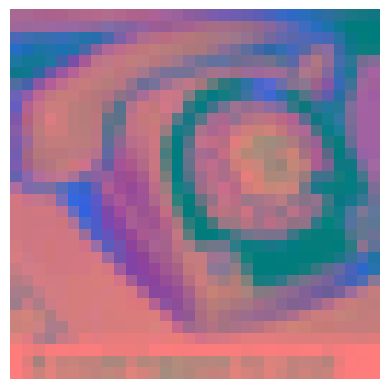

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4294967295].


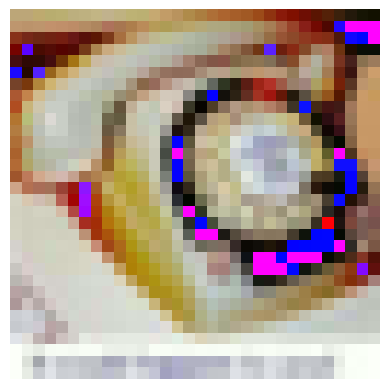

In [8]:

for Y_channel, U_binned, V_binned, fname in yuv_train_loader:

    
    U_target_rec = unbin_labels(U_binned.clone().detach())
    U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)

    V_target_rec = unbin_labels(V_binned.clone().detach())
    V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)
    
    #shape (8,3,32,32)
    img_batch = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)
    
    imggg = img_batch[5]
    imshow(imggg)
    rgb_output = yuv_rgb(imggg.permute(1,2,0))

    imshow(rgb_output) 
    
    
    break

In [9]:
'''
# RGB training data load
train_set = unpickle('train')

# Image names 
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]

# Getting the images
images_data = train_set[b'data'].copy() 
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # image name
        self.images_data = images_data # image data
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)

       
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Normalization and transforming to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
'''

In [ ]:
'''
dataset = CustomDataset(filenames=filenames, images_data=images_data,transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)
for batch in train_loader:
    image_tensor, filename = batch  # Extract data from the batch
    for idx, image_rgb in enumerate(image_tensor):
        imh_rgb = image_rgb 
        imshow(imh_rgb)
        break
    break
    '''

In [ ]:
'''
# original - created
difference = imh_rgb -rgb_output
print("R difference max: ",torch.max(difference[0,:,:]),", min :",torch.min(difference[0,:,:]))
print("G difference max: ",torch.max(difference[1,:,:]),", min :",torch.min(difference[1,:,:]))
print("B difference max: ",torch.max(difference[2,:,:]),", min :",torch.min(difference[2,:,:]))
'''

In [ ]:
# ----- CLASSIFICATION CNN MODEL -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ClassificationCNN, self).__init__()
        
        # Initial Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)
        
        x2 = self.conv2(x1_pooled)
        x2_pooled = self.pool2(x2)
        x2_pooled_padded = F.interpolate(x2_pooled, size=(32, 32), mode='bilinear', align_corners=False)

        x1_conv = self.skip0(x1)
        x2_padded = F.interpolate(x2, size=(32, 32), mode='bilinear', align_corners=False)
        el_wise = x1_conv + x2_padded
        
        # Concatenation layer
        x_concat = torch.cat([el_wise, x2_pooled_padded], dim=1) # necessitano solo stessa H e W

        # Final convolutional processing
        x_final = self.conv_final(x_concat)

        U_out = self.output_U(x_final)
        V_out = self.output_V(x_final)

        return U_out, V_out

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bin_count = 50
model = ClassificationCNN(bin_count).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
total_loss = []
# Training Loop
num_epochs = 90
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, U_target, V_target, fname in yuv_train_loader:
        Y_channel, U_target, V_target = Y_channel.permute(0,3,1,2).to(device), U_target.permute(0,3,1,2).to(device), V_target.permute(0,3,1,2).to(device)
        

        optimizer.zero_grad()
        U_pred, V_pred = model(Y_channel)
        #print('U pred: \n',U_pred)

        loss_U = criterion(U_pred, U_target.squeeze(1))
        loss_V = criterion(V_pred, V_target.squeeze(1))
        loss = loss_U + loss_V

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), f"models/classification_{num_epochs}ep.pth")

Epoch [1/90], Loss: 4.7286
Epoch [2/90], Loss: 4.6457
Epoch [3/90], Loss: 4.6211
Epoch [4/90], Loss: 4.6053
Epoch [5/90], Loss: 4.5944
Epoch [6/90], Loss: 4.5855
Epoch [7/90], Loss: 4.5783
Epoch [8/90], Loss: 4.5719
Epoch [9/90], Loss: 4.5661
Epoch [10/90], Loss: 4.5612
Epoch [11/90], Loss: 4.5557
Epoch [12/90], Loss: 4.5515
Epoch [13/90], Loss: 4.5463
Epoch [14/90], Loss: 4.5424
Epoch [15/90], Loss: 4.5382
Epoch [16/90], Loss: 4.5343
Epoch [17/90], Loss: 4.5303
Epoch [18/90], Loss: 4.5265
Epoch [19/90], Loss: 4.5238
Epoch [20/90], Loss: 4.5191
Epoch [21/90], Loss: 4.5168
Epoch [22/90], Loss: 4.5132
Epoch [23/90], Loss: 4.5100
Epoch [24/90], Loss: 4.5061
Epoch [25/90], Loss: 4.5037
Epoch [26/90], Loss: 4.4999
Epoch [27/90], Loss: 4.4980
Epoch [28/90], Loss: 4.4958
Epoch [29/90], Loss: 4.4916
Epoch [30/90], Loss: 4.4892
Epoch [31/90], Loss: 4.4860
Epoch [32/90], Loss: 4.4843
Epoch [33/90], Loss: 4.4811
Epoch [34/90], Loss: 4.4786
Epoch [35/90], Loss: 4.4766
Epoch [36/90], Loss: 4.4737
E

In [13]:
def converter(pred):
    softmax = nn.Softmax(dim = 1).to(device)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

In [14]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [21]:
model.load_state_dict(torch.load("models/classification_90ep.pth"))

<All keys matched successfully>

Filename: bos_taurus_s_000507.png


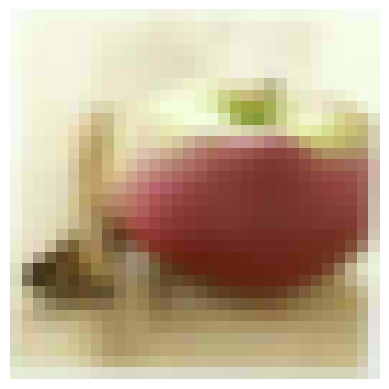

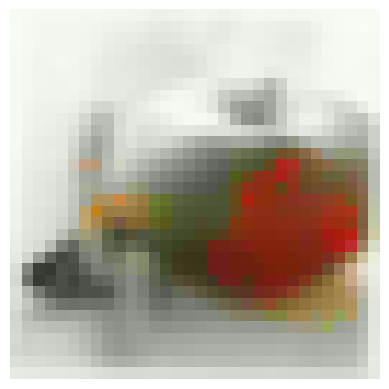

In [22]:
for Y_channel, U_target, V_target, fname in train_loader:
    Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
    
    U_pred, V_pred = model(Y_channel.permute(0,3,1,2))
    
    conv_pred_U = converter(U_pred.cpu())
    conv_pred_V = converter(V_pred.cpu())

    pred_U_rec = unbin_labels(conv_pred_U.clone().detach())
    pred_V_rec = unbin_labels(conv_pred_V.clone().detach())

    reconstructed_pred = torch.cat([Y_channel.permute(0,3,1,2).cpu(),pred_U_rec.cpu(),pred_V_rec.cpu()],dim=1)

    U_target_rec = unbin_labels(U_target)
    V_target_rec = unbin_labels(V_target)

    reconstructed_img = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)

    image_yuv = reconstructed_img[2]  
    image_yuv_pred = reconstructed_pred[2]

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    rgb_output_pred = yuv_rgb(image_yuv_pred.resize(32, 32,3))

    print(f"Filename: {fname[0]}")

    imshow(rgb_output) 
    imshow(rgb_output_pred) 
    
    
    break